In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 평가

## 정확도

In [2]:
from sklearn.base import BaseEstimator

# 성별만 보고 예측하는 Classifier 생성
class MyDummyClassifier(BaseEstimator):
  def fit(self, X, y=None):
    pass

  def predict(self, X):
    pred = np.zeros((X.shape[0], 1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i] == 1:
        pred[i] = 0
      else:
        pred[i] = 1

    return pred

In [3]:
# 피처 가공 내역 정리
from sklearn.preprocessing import LabelEncoder

def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df

def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])

  return df

def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('/content/drive/MyDrive/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print(f'Dummy Classfier의 정확도:{accuracy_score(y_test, mypredictions):.4f}')

Dummy Classfier의 정확도:0.7877


In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

digits = load_digits()

y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [6]:
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fake_pred = fakeclf.predict(X_test)
print(f'모든 예측을 0으로 하여도 정확도는:{accuracy_score(y_test, fake_pred):.3f}')

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


## 오차 행렬(Confusion Matrix)

In [7]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fake_pred)

array([[405,   0],
       [ 45,   0]])

## 정밀도(precision)와 재현율(recall)
- 정밀도: TP / (FP + TP)
  - 맞다고 예측한게 진짜 맞았을 확률
- 재현율: TP / (FN + TP)
  - 맞는 것을 맞다고 예측할 확률

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(t_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(t_test, pred)
  print('오차행렬')
  print(confusion)
  print(f'precision: {precision:.4f}, recall: {recall:.4f}')

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('/content/drive/MyDrive/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=.2, random_state=11)

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[108  10]
 [ 14  47]]
precision: 0.8246, recall: 0.7705


### Precision vs Recall : Tradeoff

In [10]:
# predict_proba(): 결정확률 도출
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 shape:', pred_proba.shape)
print('3개만 추출 \n', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('결과 \n', pred_proba_result[:3])

pred_proba() 결과 shape: (179, 2)
3개만 추출 
 [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
결과 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [12]:
from sklearn.preprocessing import Binarizer

X = [
    [1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]
]

# X의 개별 원소들이 Threshold값보다 같거나 작으면 0, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [16]:
custom_threshold = 0.5

# Positive만 추출
pred_proba1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba1)
custom_predict = binarizer.transform(pred_proba1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[108  10]
 [ 14  47]]
precision: 0.8246, recall: 0.7705


In [17]:
# 임계값을 낮추면?
custom_threshold = 0.4
pred_proba1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba1)
custom_predict = binarizer.transform(pred_proba1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[97 21]
 [11 50]]
precision: 0.7042, recall: 0.8197


In [18]:
# 모든 임계값 리스트
thresholds = [.40, .45, .50, .55, .60]


def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  for t in thresholds:
    binarizer = Binarizer(threshold=t).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', t)
    get_clf_eval(y_test, custom_predict)


get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차행렬
[[97 21]
 [11 50]]
precision: 0.7042, recall: 0.8197
임곗값: 0.45
오차행렬
[[105  13]
 [ 13  48]]
precision: 0.7869, recall: 0.7869
임곗값: 0.5
오차행렬
[[108  10]
 [ 14  47]]
precision: 0.8246, recall: 0.7705
임곗값: 0.55
오차행렬
[[111   7]
 [ 16  45]]
precision: 0.8654, recall: 0.7377
임곗값: 0.6
오차행렬
[[113   5]
 [ 17  44]]
precision: 0.8980, recall: 0.7213


In [19]:
# precision_recall_curve()
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 shape:', thresholds.shape)

반환된 분류 결정 임곗값 배열의 shape: (165,)


In [20]:
thr_idx = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 일부:', thr_idx)
print('샘플용 임계값:', np.round(thresholds[thr_idx], 2))

샘플 추출을 위한 임계값 배열의 index 일부: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 임계값: [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]


In [21]:
print('정밀도:', np.round(precisions[thr_idx], 3))
print('재현율:', np.round(recalls[thr_idx], 3))

정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


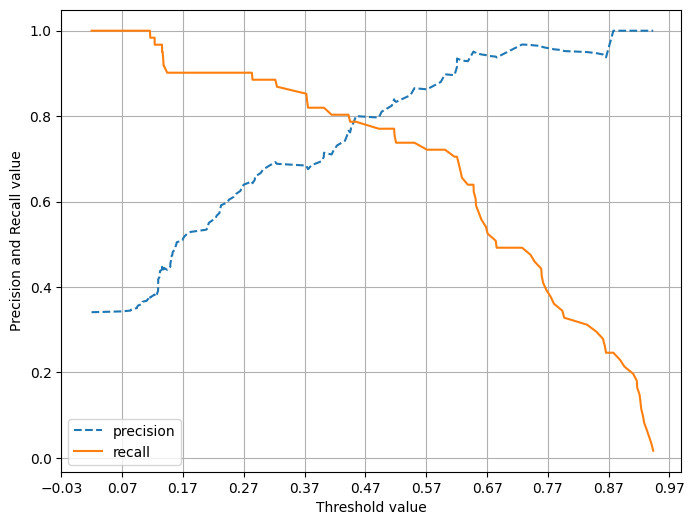

In [23]:
from ast import increment_lineno
# 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  plt.figure(figsize=(8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # X축 스케일링
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, .1), 2))

  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()


precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

## F1 스코어

F1 = $\frac{2}{\frac{1}{recall} + \frac{1}{precision}} = 2 \cdot \frac{precision \cdot recall}{precision + recall}$


In [24]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f'F1: {f1:.4f}')

F1: 0.7966


In [25]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  # f1 추가
  f1 = f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1 스코어: {f1:.4f}')


thresholds = [.4, .45, .5, .55, .6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, f1 스코어: 0.7576
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, f1 스코어: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, f1 스코어: 0.7966
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, f1 스코어: 0.7965
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, f1 스코어: 0.8000


## ROC & AUC
- ROC: FPR 변화에 따른 TPR(민감도) 변화를 그린 곡선
  - TPR(민감도, ROC 곡선의 Y축): 실제값 Positive가 정확히 예측돼야 하는 수준. $\frac{TP}{TP + FN}$

  - TNR(특이성): 실제값 Negative가 정확히 예측돼야 하는 수준. $\frac{TN}{TN + FP}$

  - $FPR = \frac{FP}{TN + FP} = 1 - TNR$ (ROC곡선의 X축)

  - 분류 결정 임계값을 변화시키면서 FPR을 0에서 1까지 움직여 그래프를 확인함.

- AUC: ROC 곡선 아래 영역의 넓이. 1에 가까울 수록 좋음.

In [32]:
# roc_curve()
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_idx = np.arange(1, thresholds.shape[0], 5)
print('index:', thr_idx)
print('thresholds:', np.round(thresholds[thr_idx], 2))

print('FPR', np.round(fprs[thr_idx], 3))
print('TPR', np.round(tprs[thr_idx], 3))

index: [ 1  6 11 16 21 26 31 36 41 46]
thresholds: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
FPR [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
TPR [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


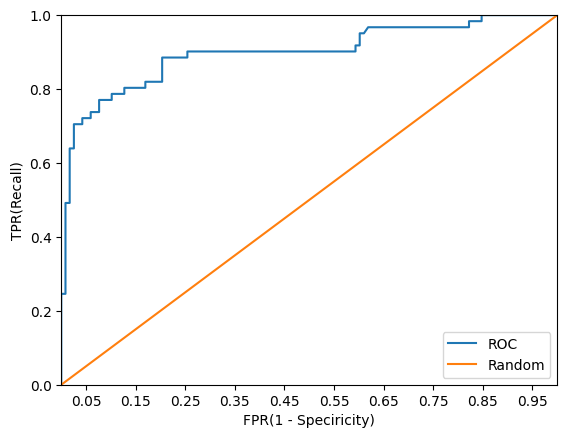

In [31]:
def roc_curve_plot(y_test, pred_proba_c1):
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  plt.plot(fprs, tprs, label='ROC')
  plt.plot([0, 1], [0, 1], label='Random')

  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, .1), 2))
  plt.xlim(0, 1); plt.ylim(0, 1)
  plt.xlabel('FPR(1 - Speciricity)'); plt.ylabel('TPR(Recall)')
  plt.legend()
  plt.show()


roc_curve_plot(y_test, pred_proba[:, 1])

In [33]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print(f'ROC AUC: {roc_score:.4f}')

ROC AUC: 0.8987


In [34]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1 스코어: {f1:.4f}, AUC: {roc_auc:.4f}')